# **Previsão básica de ações utilizando Multi Layer Perceptron**

- Diogo Nunes Batista

### Carregamento dos dados

In [640]:
import pandas
import numpy as np

df_stocks_types = {
    'ABERTURA': np.float64,
    'FECHAMENTO': np.float64,
    'VARIAÇÃO': np.float64,
    'MÍNIMO': np.float64,
    'MÁXIMO': np.float64,
    'VOLUME': str
}

df_selic_types = {
    'valor': np.float64,
}

df_stocks = pandas.read_csv('IRB_Brasil_RE_IRBR3.csv', index_col="DATA" , dtype=df_stocks_types, decimal=',')

df_selic = pandas.read_csv('selic.csv', sep=';', index_col="data",  dtype=df_selic_types , decimal=',')

print(f"df_stocks\n{df_stocks}\n\ndf_selic\n{df_selic}")

df_stocks
            ABERTURA  FECHAMENTO  VARIAÇÃO  MÍNIMO  MÁXIMO   VOLUME
DATA                                                               
25/10/2024     44.66       41.35     -6.49   41.32   44.95   99,31M
24/10/2024     47.91       44.22     -7.32   44.22   48.45  126,76M
23/10/2024     42.80       47.71     12.29   42.68   48.15  153,65M
22/10/2024     42.45       42.49      0.07   41.59   42.53   25,37M
21/10/2024     41.86       42.46      1.94   41.61   42.56   28,14M
...              ...         ...       ...     ...     ...      ...
02/05/2024     43.37       43.75      2.99   43.19   44.78   90,85M
30/04/2024     42.98       42.48     -1.26   42.29   43.78   65,25M
29/04/2024     42.15       43.02      1.58   41.53   43.27   39,72M
26/04/2024     41.53       42.35      2.69   41.25   42.76   54,96M
25/04/2024     40.80       41.24      1.18   40.30   41.40   44,64M

[129 rows x 6 columns]

df_selic
               valor
data                
02/01/2024  0.043739
03/01/202

### Tratamento dos dados

In [641]:
df_selic.rename(columns={'valor': 'SELIC'}, inplace=True)
df_selic['SELIC'] = df_selic['SELIC'] * 100

df_stocks['VOLUME'] = df_stocks['VOLUME'].str.replace('M', '').str.replace(',', '.').astype(np.float64) # Remove 'M' e subtitui ',' por '.' o que possibilita a conversão para float

df = df_stocks.join(df_selic, how='inner') # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html

df['N#'] = np.linspace(100.0, 1.0, len(df)).astype(np.float64)
 
print(df)

            ABERTURA  FECHAMENTO  VARIAÇÃO  MÍNIMO  MÁXIMO  VOLUME   SELIC  \
25/10/2024     44.66       41.35     -6.49   41.32   44.95   99.31  4.0168   
24/10/2024     47.91       44.22     -7.32   44.22   48.45  126.76  4.0168   
23/10/2024     42.80       47.71     12.29   42.68   48.15  153.65  4.0168   
22/10/2024     42.45       42.49      0.07   41.59   42.53   25.37  4.0168   
21/10/2024     41.86       42.46      1.94   41.61   42.56   28.14  4.0168   
...              ...         ...       ...     ...     ...     ...     ...   
02/05/2024     43.37       43.75      2.99   43.19   44.78   90.85  4.0168   
30/04/2024     42.98       42.48     -1.26   42.29   43.78   65.25  4.0168   
29/04/2024     42.15       43.02      1.58   41.53   43.27   39.72  4.0168   
26/04/2024     41.53       42.35      2.69   41.25   42.76   54.96  4.0168   
25/04/2024     40.80       41.24      1.18   40.30   41.40   44.64  4.0168   

                    N#  
25/10/2024  100.000000  
24/10/2024   

### Plotando

C:\Users\Diogo\AppData\Local\Temp\ipykernel_16840\3517921397.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.get_figure().show()


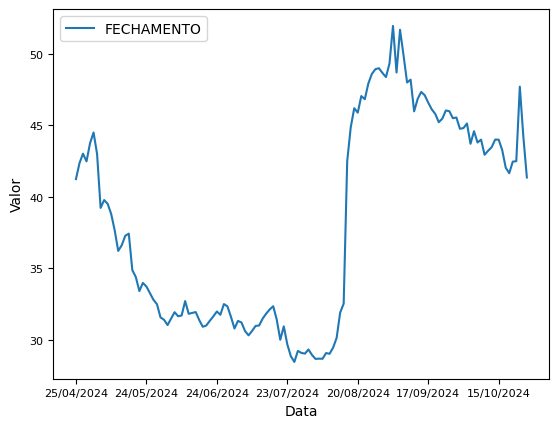

In [642]:

ax = df.iloc[::-1].plot(y='FECHAMENTO', xlabel='Data', ylabel='Valor', fontsize=8)
ax.get_figure().show()

### Separação input e target

In [643]:
df.drop(columns=['ABERTURA', 'VARIAÇÃO', 'MÍNIMO', 'MÁXIMO', 'VOLUME'], inplace=True)

df_output = df.shift(1)
df_output.dropna(inplace=True)

df_input = df.iloc[1:]

input = df_input.to_numpy() / 100.0
target = df_output['FECHAMENTO'].to_numpy().reshape(-1, 1) / 100.0

n_test = 7

# input & target for training
x = input[n_test:] 
t = target[n_test:] 

y_test = input[:n_test]
print(f"y_test\n{y_test}")

print(f"df_input\n{df_input.head(8)}")
print(f"x - first 5 rows\n{x[:5]}")
print()
print(f"df_output\n{df_output.head(8)}")
print(f"t - first 5 rows\n{t[:5]}")


y_test
[[0.4422     0.040168   0.99226563]
 [0.4771     0.040168   0.98453125]
 [0.4249     0.040168   0.97679688]
 [0.4246     0.040168   0.9690625 ]
 [0.4165     0.040168   0.96132812]
 [0.4204     0.040168   0.95359375]
 [0.4327     0.040168   0.94585937]]
df_input
            FECHAMENTO   SELIC         N#
24/10/2024       44.22  4.0168  99.226562
23/10/2024       47.71  4.0168  98.453125
22/10/2024       42.49  4.0168  97.679688
21/10/2024       42.46  4.0168  96.906250
18/10/2024       41.65  4.0168  96.132812
17/10/2024       42.04  4.0168  95.359375
16/10/2024       43.27  4.0168  94.585938
15/10/2024       44.00  4.0168  93.812500
x - first 5 rows
[[0.44       0.040168   0.938125  ]
 [0.44       0.040168   0.93039063]
 [0.4347     0.040168   0.92265625]
 [0.4322     0.040168   0.91492187]
 [0.4294     0.040168   0.9071875 ]]

df_output
            FECHAMENTO   SELIC          N#
24/10/2024       41.35  4.0168  100.000000
23/10/2024       44.22  4.0168   99.226562
22/10/2024     

### Teste

All results saved


C:\Users\Diogo\AppData\Local\Temp\ipykernel_16840\2901971288.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


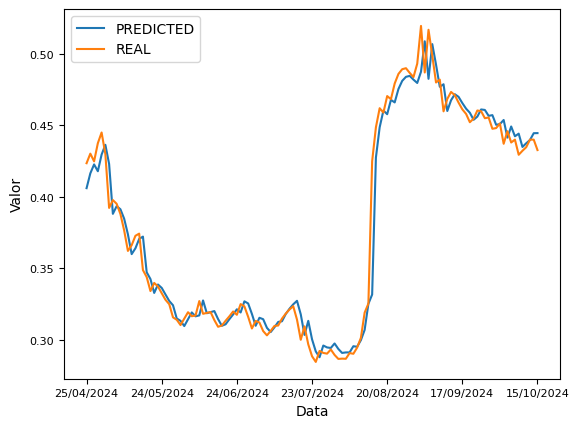

In [644]:
from typing import List
from mlp_model import MLP
from concurrent.futures import ThreadPoolExecutor

test_name = "irbr3"
test_results_dir = "results"

n, m = x.shape[1], t.shape[1]

models : List[MLP] = [
    MLP([n, 15, 10, m]),
]

learning_rate = 0.03

def run_test(i):
    mlp : MLP = models[i]
    error, epoch = mlp.train(x, t, learning_rate, max_epochs=30000, tolerated_error=1e-2)

    y = mlp.predict(x)

    return y, error, epoch

with ThreadPoolExecutor(max_workers=4) as executor:
    results = executor.map(run_test, range(len(models)))

    for i, result in enumerate(results):
        y, error, epoch = result
        
        df_result = pandas.DataFrame(
            {
                'PREDICTED': y[:,0],
                'REAL': t[:,0],
            },
            index=df_input.index[n_test:]
        )

        ax = df_result.iloc[::-1].plot(y=['PREDICTED', 'REAL'], xlabel='Data', ylabel='Valor', fontsize=8)
        fig = ax.get_figure()
        fig.savefig(f"{test_results_dir}/{test_name}_{i + 1}.png")
        fig.show()

    print("All results saved")    
        